# A/B–тестирование

In [24]:
# Подключение требуемых библиотек

import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [25]:
# Подгружаем данные

active_studs = pd.read_csv('csv/active_studs.csv')
# active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/9ExyNormZbelyg')
 
checks = pd.read_csv('csv\checks.csv', sep=';')
# url_checks = 'https://disk.yandex.ru/d/H-GJTo5Mx4Ld-g'
# checks = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_checks}', sep=';')

groups_add = pd.read_csv('csv\groups_add.csv')
# groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')

groups = pd.read_csv('csv\groups.csv', sep=';')
# groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/LIE6fUfbD7belQ', sep=';')

Объединяем groups c groups_add, так как второй файл нам прислали спустя 2 дня после передачи данных.

In [26]:
df_groups = pd.concat([groups, groups_add]).rename(columns={'id':'student_id'})
df_customers = active_studs.merge(checks, how='outer', on='student_id').fillna(0)
df = df_customers.merge(df_groups, how='left', on='student_id').fillna(0).rename(columns={'rev':'Revenue'})
print(df.shape)
df.head(2)

(8490, 3)


,student_id,Revenue,grp
0,581585,0.0,A
1,5723133,0.0,A


### На какие метрики Вы смотрите в ходе анализа и почему?
По условию задачи не совсем понятно что значит "новая механика оплаты услуг на сайте". Можно предположить, что новая механика оплаты была введена дабы стимулировать рост продаж определенного продукта. Исходя из предположений, в ходе анализа будем смотреть на метрику ARPPU (средний чек пользователей, которые совершили покупку) и метрику CR (конвертация пользователей, постетивших сайт, в покупку).

Для того, чтобы рассчитать ARPPU и CR, нужно подготовить данные. Для этого создам дополнительный датасет для рассчета.

In [27]:
df_1 = df.query('Revenue>0') \
        .groupby('grp', as_index=False).sum()

df_1['buyers'] = df.query('Revenue>0') \
                    .groupby('grp', as_index=False) \
                    .count()['Revenue']

df_1['total_users'] = df.groupby('grp', as_index=False).count()['student_id']
df_1.head()

,grp,student_id,Revenue,buyers,total_users
0,A,275727655,92096.0000,107,1567
1,B,1084763905,481230.0036,434,6923


Теперь можно рассчитать выбранные метрики

# ARPPU
#### Формула:
$$ ARPPU⠀=⠀{Доход⠀компании⠀за⠀период \over Количество⠀покупателей} $$

In [28]:
metrics = df_1[['grp']].copy()
metrics['ARPPU'] = (df_1['Revenue'] / df_1['buyers']).round(2)
metrics

,grp,ARPPU
0,A,860.71
1,B,1108.82


# Conversion rate
#### Формула:
$$ CR⠀=⠀{Число⠀посетителей,⠀совершивших⠀целевое⠀действие \over Общее⠀кол-во⠀посетителей}⠀*⠀100% $$

In [29]:
metrics['CR'] = (df_1['buyers'] / df_1['total_users'] * 100).round(2)
metrics 

,grp,ARPPU,CR
0,A,860.71,6.83
1,B,1108.82,6.27


Text(0.5, 1.0, 'Revenue_control')

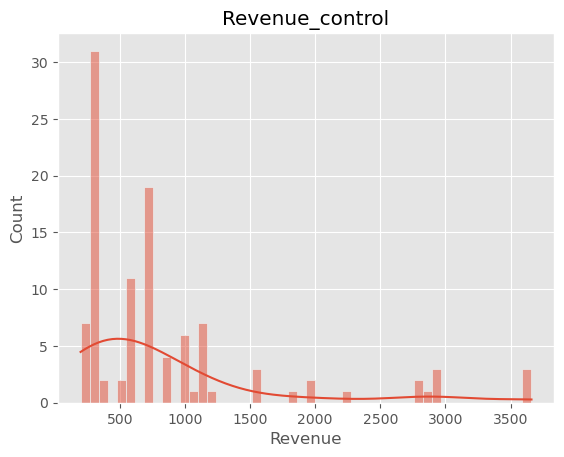

In [30]:
 sns.histplot(
    df.query('Revenue>0').query('grp=="A"')['Revenue'],
    bins=50, kde=True).set_title("Revenue_control")

Text(0.5, 1.0, 'Revenue_target')

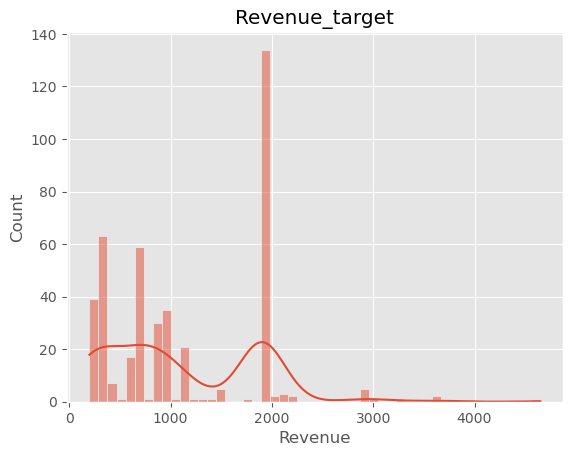

In [31]:
 sns.histplot(
    df.query('Revenue>0').query('grp=="B"')['Revenue'],
    bins=50, kde=True).set_title("Revenue_target")

### Имеются ли различия в показателях и с чем они могут быть связаны?

Различия в показателях действительно есть, но говорить о их значимости пока рано. Видно, что ARPPU у целевой группы(В) повысился, но также, из визуализации выше можно видеть что это скорее всего обусловлено резким ростом числа покупок в одном ценовом сегменте. CR же выше у контрольной группы(А). Что бы понять, является ли полученный результат статистически значимым, сформулируем и проверим гипотезы.


 - Гипотезы об ARPPU:
 
 
H0_1 - Различий между показателями ARPPU нет (новая механика оплаты не приводит к изменению ARPPU)  
H1_1 - Различия между показателями есть (новая механика оплаты приводит к изменению ARPPU)



 - Гипотезы об CR:
 
 
 H0_2- Различий между показателями CR нет (новая механика оплаты не приводит к изменению CR)  
H1_2 - Различия между показателями есть (новая механика оплаты приводит к изменению CR)

### Проверка гипотез об ARPPU
 
Исходя из визуализации и данных выше, видно, что распределение покупок среди пользователей не является нормальным и количество наблюдений в выборках разное. Для проверки статистическйо значимости различий в показателе ARPPU применим Бутстрап

# **Бутстрап**

In [32]:
df_A = df.query('Revenue>0').query('grp=="A"')['Revenue']
df_B = df.query('Revenue>0').query('grp=="B"')['Revenue']

def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean,
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    
# Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()   
      
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|██████████| 1000/1000 [00:00<00:00, 12717.68it/s]


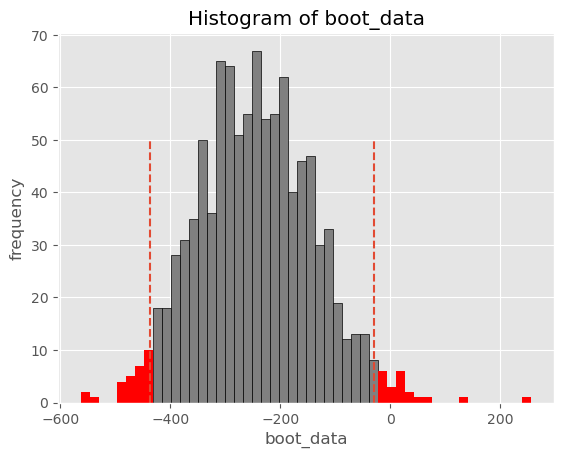

In [33]:
booted_data = get_bootstrap(df_A, df_B)

In [34]:
booted_data["p_value"]

0.020664436622379684

In [35]:
booted_data["quants"]

,0
0.025,-437.254451
0.975,-29.862624


В итоге проверки выяснилось, что ARPPU в результате появления нового механизма оплаты уменьшился, получается что мы отклоняем нулевую гипотезу, так как p-value меньше 0.05. Результаты теста не подтвердили предположение о том, что ARPPU увеличилcя.

### Проверка CR
Для категориальных переменных можно использовать метод Хи-квадрат

In [36]:
df_1

,grp,student_id,Revenue,buyers,total_users
0,A,275727655,92096.0000,107,1567
1,B,1084763905,481230.0036,434,6923


In [37]:
data = np.array([ [df_1.query('grp=="A"').total_users, df_1.query('grp=="A"').buyers],\
                [df_1.query('grp=="B"').total_users, df_1.query('grp=="B"').buyers]  ])


chi2, prob, df, expected = scipy.stats.chi2_contingency(data)
print("p-value: {}".format(prob))

p-value: 0.4778925970224768


В результате анализа с Хи-квадрат выяснилось, что CR после появления нового механизма оплаты не изменился. Можно принять нулевую гипотезу, так как p-value больше 0.05

### Стоит ли запускать новую механику на всех пользователей?

После проведения всех тестов, можно сказать, что новая механика оплаты не приводит к статистически значимым результатам и запускатьее на всех пользователей не стоит.

-----